In [1]:
# let's construct some catalogues that can be used in treecorr directly!
# First some imports that we'll use below
from __future__ import print_function
import treecorr
#import fitsio
from astropy.io import fits
import numpy
import time
import pprint
import healpy as hp

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

0.13312784830729166 5491.917967439271


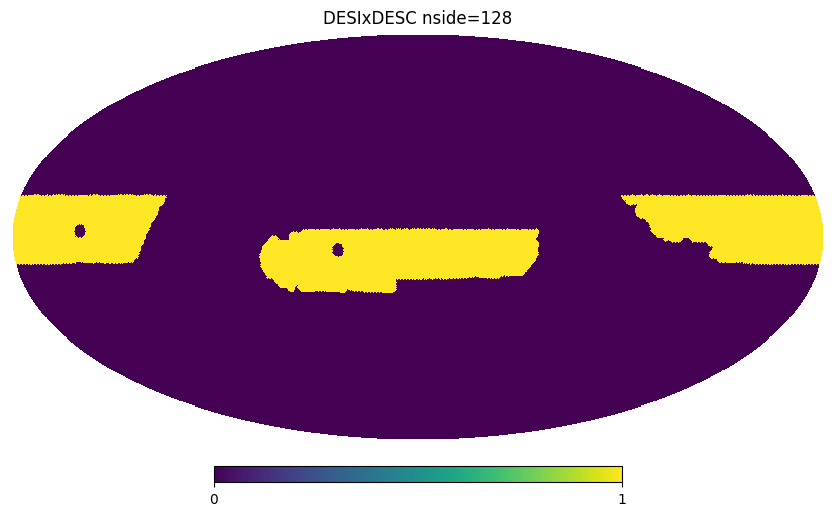

In [8]:
# get desi x desc mask:
fname = "/pscratch/sd/q/qhang/rubin_baseline_v2/"
fname += "wfd_footprint_nvisitcut_500_nside_128.fits"
wfd_mask = hp.read_map(fname)
    
fname = "/pscratch/sd/q/qhang/rubin_baseline_v2/"
fname += "DESI_footprint_completeness_mask_128.fits"
desi_mask = hp.read_map(fname)
desi_mask[desi_mask<0]=0

mask = wfd_mask*desi_mask
mask[mask>0]=1

hp.mollview(mask, title="DESIxDESC nside=128")

# print fsky, area in deg^2:
fsky = np.mean(mask)
sky_area = 4*np.pi*(180/np.pi)**2*fsky
print(fsky, sky_area)

In [10]:
hp.write_map("/pscratch/sd/q/qhang/desi-lya/desixlsst-mask-nside-128.fits", mask)

setting the output map dtype to [dtype('float64')]


In [9]:
# def save fits file:
def save_catalog_to_fits(fname, data_matrix):
    c=[]
    dtype_to_fits_type = {'int64': 'K',
                          'float64': 'D',
                          'float32': 'E',
                          '<U6': '20A',
                          'bool': 'bool',
                          '>f8': 'D',
                          '>f4': 'E',
                         }
    
    for ii, keys in enumerate(data_matrix.keys()):
        col=fits.Column(name=keys, array=data_matrix[keys],
                        format=dtype_to_fits_type[str(data_matrix[keys].dtype)])
        c.append(col)
    t = fits.BinTableHDU.from_columns(c)
    t.writeto(fname)

## Let's save a full catalogue for the photometric sample in this overlap

In [13]:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/test_box/gal_box/results/"

data_holder={}
columns = ['Z_COSMO','DZ_RSD','RA','DEC']
pixels_inmask = np.arange(len(mask))[mask.astype(bool)]
nside=128

# we only need ra, dec, redshifts:
for ii in range(128):
    
    if ii%30==0:
        print(f"Working on {ii+1}/128...")
    
    fname = root + f"out_srcs_s2_{ii}.fits"
    f=fits.open(fname)
    
    ra = f[1].data['RA']
    dec = f[1].data['DEC']
    redshift = f[1].data['Z_COSMO'] + f[1].data['DZ_RSD']
    
    pix = hp.ang2pix(nside,
                 np.radians(90 - dec),
                 np.radians(ra))
    
    sel = np.isin(pix, pixels_inmask)
    sel *= redshift >= 1.0
    
    if len(ra[sel])>0:
        for col in columns:
            if ii == 0:
                data_holder[col] = f[1].data[col][sel]
            else:
                data_holder[col] = np.append(data_holder[col], f[1].data[col][sel])

print(len(data_holder['Z_COSMO']))

In [15]:
print(len(data_holder['Z_COSMO']))

425235016


In [14]:
# now save:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
fname = saveroot + "photometry-catalogue-overlap.fits"
save_catalog_to_fits(fname, data_holder)

In [ ]:
# now grab the delta_F files, select objects inside these chunks, save a separate file called test:
num = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,28,30]
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/"

# for each tomo bin
nside=8
data_holder = {}
for tomo in range(1, 19):
    data_holder[tomo] = {}

for ii in num:
    fname = root + f"pixgroup_{ii}.fits"
    fin = fits.open(fname)
    
    ra = fin[1].data['RA']
    dec = fin[1].data['DEC']
    zbin = fin[1].data['Z_BIN']
    
    pix = hp.ang2pix(nside,
                 np.radians(90 - dec),
                 np.radians(ra))
    sel = np.isin(pix, unique_pix_nside8)
    
    for tomo in range(1, 19):
        sel2 = zbin[sel] == tomo
        for key in fin[1].columns.names:
            if ii == 0:
                data_holder[tomo][key] = fin[1].data[key][sel][sel2]
            else:
                data_holder[tomo][key] = np.append(data_holder[tomo][key], fin[1].data[key][sel][sel2])

In [ ]:
# make catalog ob
for tomo in range(1, 19):
    print(len(data_holder[tomo]['RA']))

In [ ]:
root = "/pscratch/sd/q/qhang/desi-lya/"
for tomo in range(1, 18):
    fname = root + f"test_datasets/test-delta_F-zsamp-{tomo}.fits"
    save_catalog_to_fits(fname, data_holder[tomo])